In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from argparse import Namespace

import slowfast.utils.checkpoint as cu
from slowfast.utils.parser import load_config
from slowfast.models import build_model

/usr/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
args = Namespace()
args.opts = None
# path_to_config = 'configs/ImageNet/REV_MVIT_B_16_CONV.yaml'
path_to_config = 'configs/ImageNet/REV_VIT_S.yaml'
path_to_checkpoint = 'REV_VIT_S.pyth'

cfg = load_config(args, path_to_config)
cfg.NUM_GPUS = 1

In [4]:
model = build_model(cfg)
model.eval()

MViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (rev_backbone): ReversibleMViT(
    (layers): ModuleList(
      (0-11): 12 x ReversibleBlock(
        (F): AttentionSubBlock(
          (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (q): Linear(in_features=384, out_features=384, bias=True)
            (k): Linear(in_features=384, out_features=384, bias=True)
            (v): Linear(in_features=384, out_features=384, bias=True)
            (proj): Linear(in_features=384, out_features=384, bias=True)
          )
        )
        (G): MLPSubblock(
          (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_features=384, bias=True)
          )
        )
      )
    )
  )
 

In [5]:
epoch = cu.load_checkpoint(
    path_to_checkpoint,
    model,
    data_parallel=False,  # when NUM_GPUS is 1
    # optimizer=None,
    # scaler=None,
    # inflation=False,
    # convert_from_caffe2=False,
    # epoch_reset=False,
    # clear_name_pattern=(),
    # image_init=False,
)

missing keys: []
unexpected keys: []


In [6]:
import torch

device = next(model.parameters()).device

# N x T x C x H x W (T=1 frame, i.e., not video)
x = torch.rand((1, 1, 3, 224, 224)).to(device)
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([1, 1000])

In [7]:
def patch_embed(model, x):
    x = x[0]
    x, bcthw = model.patch_embed(x)  # TODO: invert me
    bcthw = list(bcthw)
    if len(bcthw) == 4:  # Fix bcthw in case of 4D tensor
        bcthw.insert(2, torch.tensor(model.T))
    T, H, W = bcthw[-3], bcthw[-2], bcthw[-1]
    assert len(bcthw) == 5 and (T, H, W) == (model.T, model.H, model.W), bcthw
    B, N, C = x.shape

    s = 1 if model.cls_embed_on else 0
    if model.use_fixed_sincos_pos:
        raise NotImplementedError('inversion')
        x += model.pos_embed[:, s:, :]  # s: on/off cls token

    if model.cls_embed_on:
        raise NotImplementedError('inversion')
        cls_tokens = model.cls_token.expand(
            B, -1, -1
        )  # stole cls_tokens impl from Phil Wang, thanks
        if model.use_fixed_sincos_pos:
            cls_tokens = cls_tokens + model.pos_embed[:, :s, :]
        x = torch.cat((cls_tokens, x), dim=1)

    if model.use_abs_pos:
        if model.sep_pos_embed:
            raise NotImplementedError('inversion')
            pos_embed = model.pos_embed_spatial.repeat(
                1, model.patch_dims[0], 1
            ) + torch.repeat_interleave(
                model.pos_embed_temporal,
                model.patch_dims[1] * model.patch_dims[2],
                dim=1,
            )
            if model.cls_embed_on:
                raise NotImplementedError('inversion')
                pos_embed = torch.cat([model.pos_embed_class, pos_embed], 1)
            x += model._get_pos_embed(pos_embed, bcthw)
        else:
            x += model._get_pos_embed(model.pos_embed, bcthw)  # TODO: invert me

    if model.drop_rate:
        raise NotImplementedError('inversion')
        x = model.pos_drop(x)

    if model.norm_stem:
        raise NotImplementedError('inversion')
        x = model.norm_stem(x)
    return x

In [8]:
print(model.use_fixed_sincos_pos)

False


In [9]:
rev = model.rev_backbone

with torch.no_grad():
    x_embed = patch_embed(model, x)
    z = rev(x_embed)
    x_embed_recovered = rev.inverse(z)

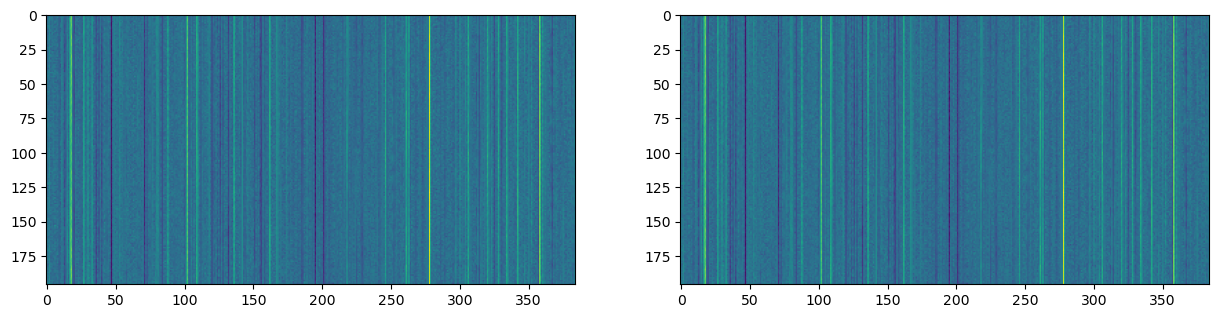

In [10]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.imshow(x_embed_recovered.cpu().numpy()[0])
ax2.imshow(x_embed.cpu().numpy()[0])

In [49]:
input.shape, out.shape

(torch.Size([1, 3, 12, 12]), torch.Size([1, 5, 11, 11]))

In [81]:
b.transpose(0, 1).shape

torch.Size([3, 10, 16, 16])

In [87]:
a = torch.rand(1, 10)
b = torch.rand(10, 3, 16, 16)
(torch.tensordot(a, b, dims=1)).shape

torch.Size([1, 3, 16, 16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 12, 12])


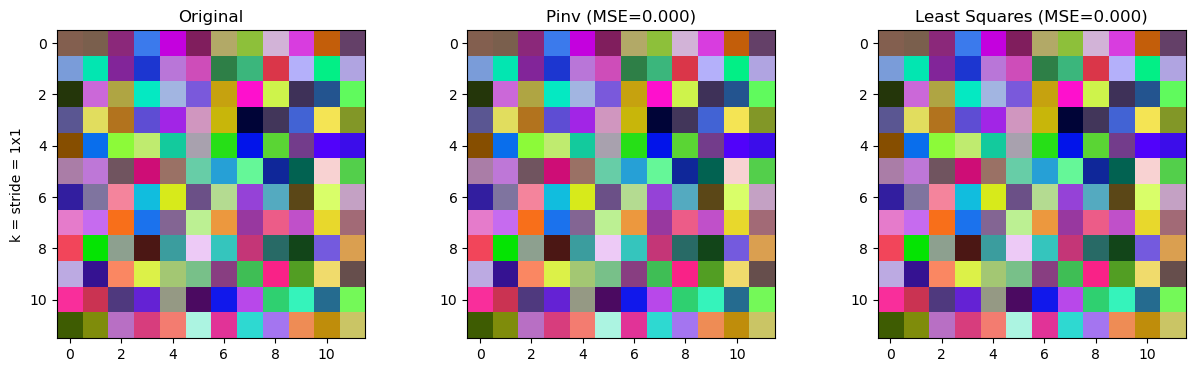

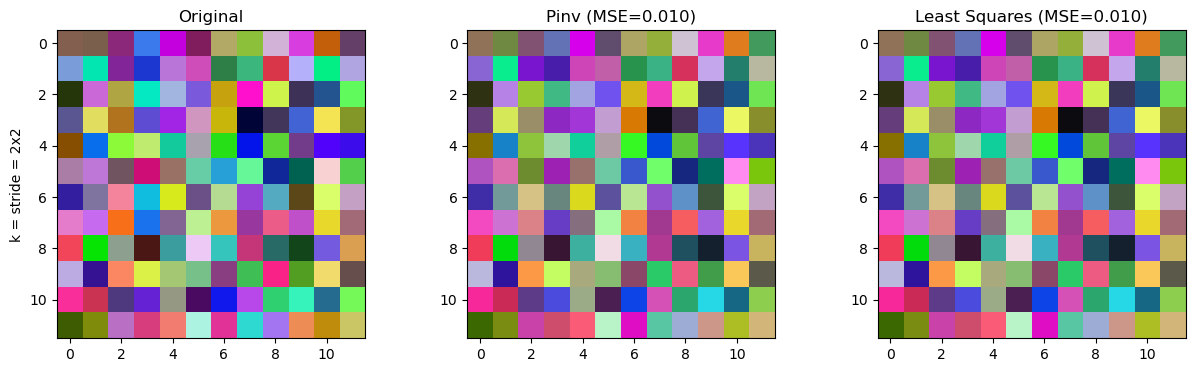

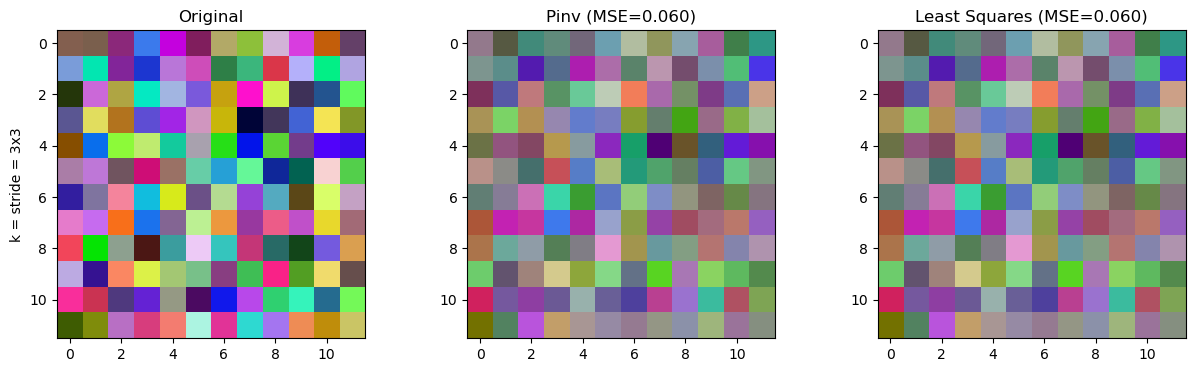

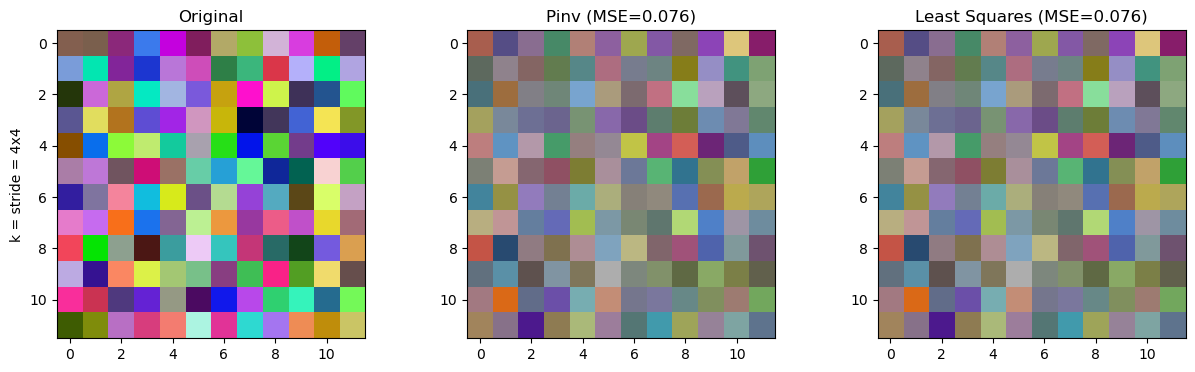

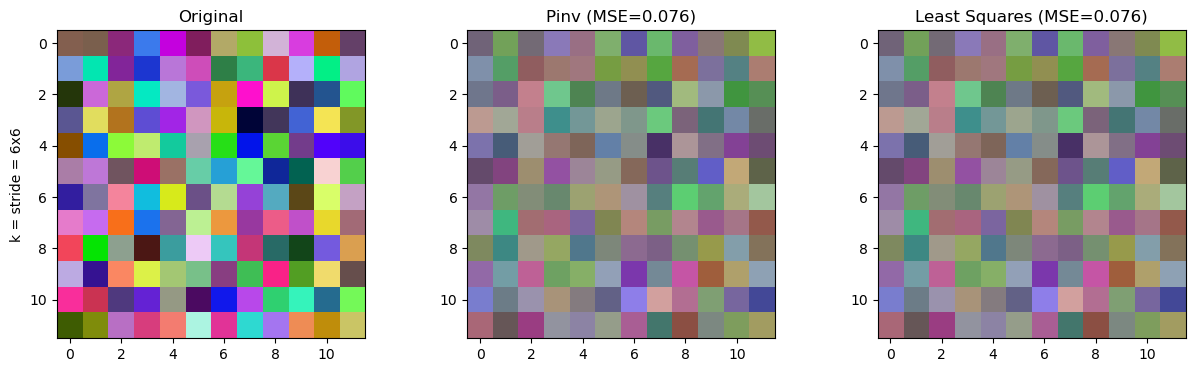

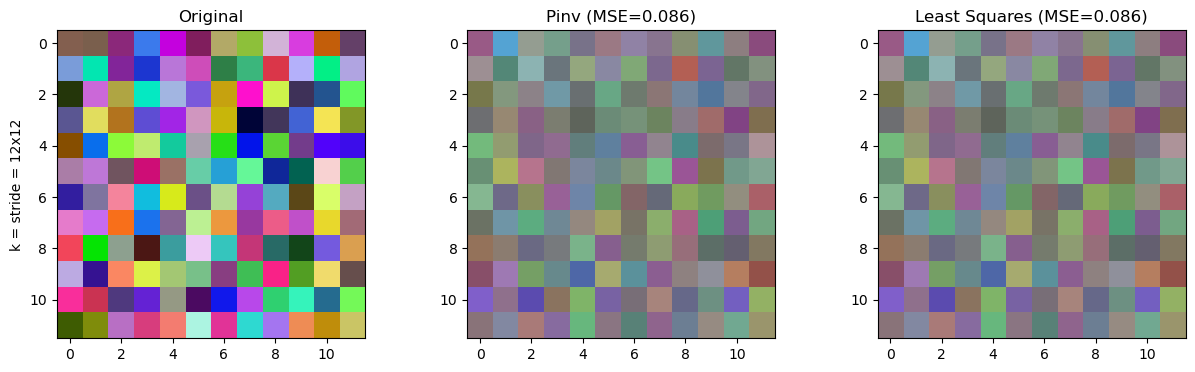

In [145]:
from torch.nn.functional import conv2d, conv_transpose2d

# k = 12
h, w = 12, 12
c_out = 10
input = torch.rand(1, 3, h, w)
for k in [1, 2, 3, 4, 6, 12]:
    stride = k
    weight = torch.rand((c_out, 3, k, k))
    out = conv2d(input, weight, stride=stride)
    
    weight_inv = torch.linalg.pinv(weight.reshape(c_out, -1)).T.reshape(weight.shape)
    
    # input_rec = conv_transpose2d(out, weight, stride=stride)
    input_rec = conv_transpose2d(out, weight_inv, stride=stride)
    # input_rec = torch.zeros_like(input)
    # for i in range(out.shape[-2]):
    #     for j in range(out.shape[-1]):
    #         # 1 x C x 1 x 1 -> 1 x 3 x 16 x 16
    #         input_rec[:, :, i * k:(i + 1) * k, j * k:(j + 1) * k] = torch.tensordot(out[:, :, i, j], weight, dims=1)
    # print(input_rec)
    # print(conv_transpose2d(out, weight, stride=stride))
    # pos_weights = conv_transpose2d(torch.ones_like(out), torch.ones_like(weight))
    # print(input.shape, input.dtype)
    # print(input_rec.shape, input_rec.dtype)
    # print(out.shape, out.dtype)
    
    # # Also how to do convolution hehe:
    # s = input.shape[-2:]
    # # K_f = torch.fft.rfftn(weight, s)
    # # x_f = torch.fft.rfftn(input, s)
    # # y_f = torch.einsum('jkxy,ikxy->ijxy', K_f.conj(), x_f)
    # # y_hat = torch.fft.irfftn(y_f, s)
    # # print(torch.mean((out - y_hat) ** 2) / torch.mean(out ** 2))
    # # print(torch.mean((out - y_hat) ** 2))
    # 
    # out_cpy = out.clone()
    # # if out_cpy.shape != out.shape:
    # #     out_cpy = torch.nn.functional.pad(out_cpy, (1, 0, 1, 0))
    # # out_cpy[:, :, h - (k - 1):, :] = 0
    # # out_cpy[:, :, :, w - (k - 1):] = 0
    # 
    # s = out.shape[-2:]  # TODO
    # K_f = torch.fft.rfftn(weight, s)
    # K_f_inv = torch.linalg.pinv(K_f.T).T
    # y_f = torch.fft.rfftn(out_cpy, s)
    # # y_f = torch.fft.rfftn(y_hat, s)
    # x_f = torch.einsum('jkxy,ikxy->ijxy', K_f_inv.conj(), y_f)
    # x_hat = torch.fft.irfftn(x_f, s)
    # # print(x_hat.shape, input.shape)
    # # print(torch.mean((input - x_hat) ** 2) / torch.mean(input ** 2))
    # # print(torch.mean((input - x_hat) ** 2))
    
    # TODO: not convinced that this is right....
    input_rec_2_flat = torch.linalg.lstsq(
        weight.reshape(c_out, -1),  # Co x Ci x K x K --> Co x CiKK
        out.transpose(0, 1).reshape(c_out, -1)  # N x Co x H' x W' --> Co x NH'W'
    ).solution  # solution: CiKK x NH'W'
    h_, w_ = out.shape[-2:]
    n_samples = 1
    n_chunks = input_rec_2_flat.shape[-1] // n_samples
    
    input_rec_2_flat = input_rec_2_flat.reshape(3, k, k, n_samples, h_, w_)
    input_rec_2_flat = input_rec_2_flat.permute(3, 0, 1, 2, 4, 5)  # N x Ci x K x K x H' x W'
    input_rec_2 = torch.zeros_like(input)  # (n_samples, 3, h, w)
    
    for i in range(h_):
        for j in range(w_):
            input_rec_2[:, :, i * k:(i + 1) * k, j * k:(j + 1) * k] = input_rec_2_flat[:, :, :, :, i, j]
    
    if False:  # TODO least squares for weight inverse
        input_rec_3 = torch.linalg.lstsq(out.reshape(-1, c_out), input.reshape(-1, 3 * k * k)).solution
        n_samples = 1
        n_chunks = input_rec_3.shape[-1] // n_samples
        input_rec_3 = input_rec_3.reshape(3, k * k, n_samples, n_chunks).permute(2, 0, 1, 3)
        input_rec_3 = input_rec_3.reshape(n_samples, 3, h, w)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    ax1.imshow(input.cpu().numpy()[0].transpose(1, 2, 0))
    ax1.set_title('Original')
    ax1.set_ylabel(f'k = stride = {k}x{k}')
    
    # input_rec_npy = (x_hat).cpu().numpy()[0].transpose(1, 2, 0)
    # input_rec_npy = (input_rec / pos_weights).cpu().numpy()[0].transpose(1, 2, 0)
    input_rec_npy = input_rec.cpu().numpy()[0].transpose(1, 2, 0)
    # input_rec_npy = (input_rec_npy - input_rec_npy.min()) / (input_rec_npy.max() - input_rec_npy.min())
    # ax2.imshow(input_rec_npy / input_rec_npy.max())
    ax2.imshow(input_rec_npy)
    ax2.set_title(f'Pinv (MSE={((input_rec - input) ** 2).mean():.3f})')
    
    print(input_rec_2.shape)
    input_rec_npy_2 = input_rec_2.cpu().numpy()[0].transpose(1, 2, 0)
    ax3.imshow(input_rec_npy_2)
    ax3.set_title(f'Least Squares (MSE={((input_rec_2 - input) ** 2).mean():.3f})')

torch.Size([27, 16])


torch.Size([1, 3, 144])